In [1]:
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline

/home/wedeueis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

#net configuration
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1
#Optimizers lr
learning_rate = 0.002

data = input_data.read_data_sets('data/MNIST/', one_hot=True)
data.test.cls = np.argmax(data.test.labels, axis=1)

print("Size of:")
print("- Training set:\t\t{}".format(len(data.train.labels)))
print("- Test set:\t\t{}".format(len(data.test.labels)))
print("- Validation set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training set:		55000
- Test set:		10000
- Validation set:	5000


In [3]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.nn.tanh(logits)
        
        return out, logits

In [4]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits



In [5]:
# Create our input placeholders
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    return inputs_real, inputs_z

In [6]:
tf.reset_default_graph()

#Inputs
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model, g_logits = generator(input_z, input_size, g_hidden_size, reuse=False,  alpha=alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, d_hidden_size, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, d_hidden_size, reuse=True, alpha=alpha)

In [7]:
# Calculate losses
d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)

d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_fake), logits=d_logits_fake))

In [8]:
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

# Optimizers
d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [9]:
batch_size = 64
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(data.train.num_examples//batch_size):
            batch = data.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, reuse=True),feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3734... Generator Loss: 3.6777
Epoch 2/100... Discriminator Loss: 0.4803... Generator Loss: 3.2842
Epoch 3/100... Discriminator Loss: 0.5383... Generator Loss: 4.2597
Epoch 4/100... Discriminator Loss: 0.6543... Generator Loss: 2.9648
Epoch 5/100... Discriminator Loss: 0.5934... Generator Loss: 5.0395
Epoch 6/100... Discriminator Loss: 0.8790... Generator Loss: 2.4437
Epoch 7/100... Discriminator Loss: 0.9991... Generator Loss: 3.5401
Epoch 8/100... Discriminator Loss: 0.8769... Generator Loss: 2.7169
Epoch 9/100... Discriminator Loss: 0.7678... Generator Loss: 2.7519
Epoch 10/100... Discriminator Loss: 0.8891... Generator Loss: 3.0615
Epoch 11/100... Discriminator Loss: 0.9906... Generator Loss: 2.2570
Epoch 12/100... Discriminator Loss: 0.9484... Generator Loss: 2.7379
Epoch 13/100... Discriminator Loss: 1.1040... Generator Loss: 1.5678
Epoch 14/100... Discriminator Loss: 1.2529... Generator Loss: 1.4698
Epoch 15/100... Discriminator Loss: 1.1383.

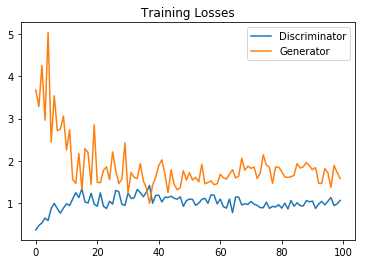

In [10]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

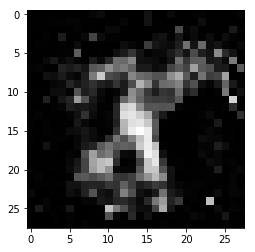

In [60]:
plt.imshow(np.reshape(samples[99][0][0],(28,28)), cmap='Greys_r')

In [64]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(),samples[epoch][0]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(np.reshape(img, (28,28)), cmap='Greys_r')
    
    return fig, axes

In [65]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

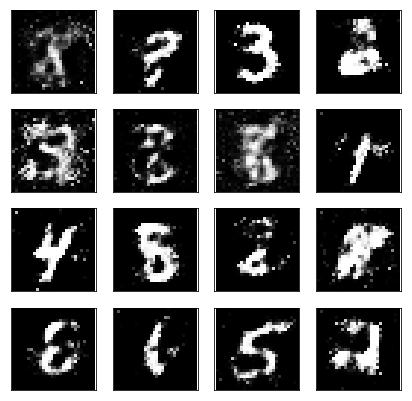

In [67]:
_ = view_samples(-1, samples)

In [124]:
samples[::10][0]

(array([[-0.24033636, -0.19719546, -0.27258423, ..., -0.32477394,
         -0.22491139, -0.24373232],
        [-0.339697  , -0.2772766 , -0.36945403, ..., -0.4205179 ,
         -0.2265257 , -0.2695794 ],
        [-0.30214944, -0.3228222 , -0.3623678 , ..., -0.47104084,
         -0.3528747 , -0.3566465 ],
        ...,
        [-0.25207278, -0.22447339, -0.29100904, ..., -0.3583249 ,
         -0.25472882, -0.26954168],
        [-0.36569494, -0.291077  , -0.39254516, ..., -0.436397  ,
         -0.2141917 , -0.26600993],
        [-0.31716064, -0.38038328, -0.39630952, ..., -0.53462154,
         -0.42708674, -0.41715845]], dtype=float32),
 array([[-0.24513106, -0.19981284, -0.27965337, ..., -0.3369748 ,
         -0.22882321, -0.24873835],
        [-0.35375   , -0.28472945, -0.38779068, ..., -0.44832098,
         -0.23052418, -0.27641022],
        [-0.31188333, -0.3347945 , -0.37960893, ..., -0.51140714,
         -0.36872354, -0.3730384 ],
        ...,
        [-0.257625  , -0.22836192, -0.2

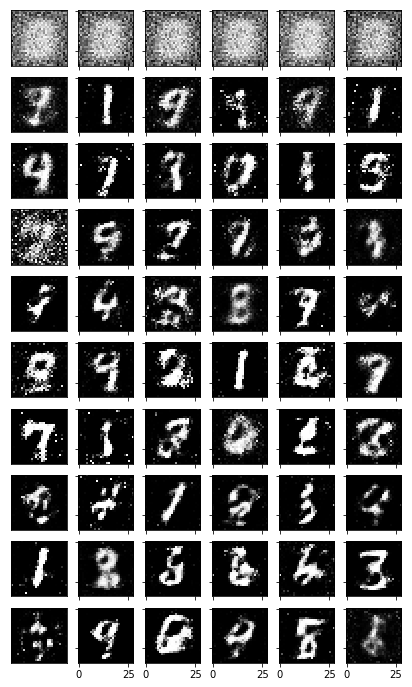

In [173]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for ax_row, sample in zip(axes, samples[::int(len(samples)/rows)]):
    for ax, img  in zip(ax_row, sample[::int(len(samples)/cols)]):
        ax_row[0].imshow(np.reshape(img[0],(28,28)), cmap='Greys_r')
        ax_row[1].imshow(np.reshape(img[1],(28,28)), cmap='Greys_r')
        ax_row[2].imshow(np.reshape(img[2],(28,28)), cmap='Greys_r')
        ax_row[3].imshow(np.reshape(img[3],(28,28)), cmap='Greys_r')
        ax_row[4].imshow(np.reshape(img[4],(28,28)), cmap='Greys_r')
        ax_row[5].imshow(np.reshape(img[5],(28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<matplotlib.figure.Figure at 0x7f9373b3b8d0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93a86e78d0>,
       dtype=object))

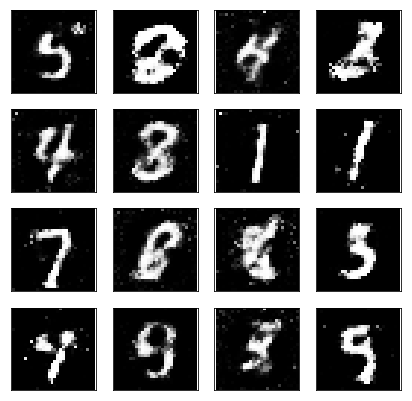

In [111]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, reuse=True),feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])
